# JaCoCo Visualization

In [129]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

jacoco_path = '../../generated/code-analysis/jacoco.csv'

if not os.path.exists(jacoco_path):
    raise FileNotFoundError(f"Le fichier JaCoCo n'existe pas : {jacoco_path}. Exécutez le notebook 'notebooks/arrange data/JaCoCo.ipynb' pour le générer.")

out_jacoco_path = '../../generated/figures/jacoco'
if not os.path.exists(out_jacoco_path):
    os.makedirs(out_jacoco_path)

df_jacoco = pd.read_csv(jacoco_path)
cols = ['instruction', 'branch', 'line', 'method']

# Effet d'ordre

In [130]:
from statsmodels.stats.weightstats import ttost_ind

results = []
low_eq_bound = -0.1
high_eq_bound = 0.1

for metric in cols:
    pivot = df_jacoco.pivot(index='user', columns='game_mode', values=metric)
    pivot = pivot.dropna()

    groups = df_jacoco.drop_duplicates('user')[['user', 'group']]
    pivot = pivot.merge(groups.set_index('user'), left_index=True, right_index=True)

    pivot['diff'] = pivot.apply(
        lambda row: row['leaderboard'] - row['achievements'] if row['group'] == 'A'
                    else row['achievements'] - row['leaderboard'],
        axis=1
    )

    group_a = pivot[pivot['group'] == 'A']['diff'].values.flatten()
    group_b = pivot[pivot['group'] == 'B']['diff'].values.flatten()

    assert len(group_a) == len(group_b), f"Mismatch in sample size for {metric}"

    _, p_normal_diff_a = stats.shapiro(group_a)
    _, p_normal_diff_b = stats.shapiro(group_b)

    # Test variance
    stat, variance_p_value = stats.levene(group_a, group_b)

    p_value, data1, data2 = ttost_ind(group_a, group_b, low_eq_bound, high_eq_bound)

    results.append([
        metric.capitalize(),
        p_normal_diff_a > 0.05,
        p_normal_diff_b > 0.05,
        variance_p_value > 0.05,
        p_value,
        p_value < 0.05
    ])

order_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'p_value',
    'significant'
])

order_effect_df

,metric,a_normal,b_normal,variance_equals,p_value,significant
0,Instruction,False,True,True,0.026632,True
1,Branch,False,True,True,0.019883,True
2,Line,True,True,True,0.054580,False
3,Method,True,True,True,0.052466,False


# Effet de session

In [131]:
import numpy as np
from scipy.stats import bootstrap

results = []
alpha = 0.05

low_eq_bound = -0.05
high_eq_bound = 0.05

def diff_mean(data1, data2):
    return np.mean(data1) - np.mean(data2)

for metric in cols:
    df_rounds = df_jacoco.copy()

    session1 = df_rounds[df_rounds['session'] == 1][metric].values.flatten()
    session2 = df_rounds[df_rounds['session'] == 2][metric].values.flatten()

    assert len(session1) == len(session2), f"Mismatch in sample size for {metric}"

    # Normalité ?
    _, p_shapiro_1 = stats.shapiro(session1)
    _, p_shapiro_2 = stats.shapiro(session2)

    # Test variance
    stat, variance_p_value = stats.levene(session1, session2)

    res = bootstrap(
        data=(session1, session2),
        statistic=diff_mean,
        paired=True,
        vectorized=False,
        confidence_level=0.95,
        n_resamples=10000,
        method="basic"
    )

    results.append([
        metric.capitalize(),
        p_shapiro_1 >= alpha,
        p_shapiro_2 >= alpha,
        variance_p_value >= alpha,
        res.confidence_interval.low > low_eq_bound and res.confidence_interval.high < high_eq_bound
    ])

session_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'session1_normal',
    'session2_normal',
    'variance_equals',
    'equivalent'
])

session_effect_df

,metric,session1_normal,session2_normal,variance_equals,equivalent
0,Instruction,False,True,True,False
1,Branch,False,True,True,False
2,Line,False,True,True,False
3,Method,False,True,True,True


In [132]:
session_effect_df_count = len(session_effect_df[session_effect_df['significant'] == True])
if session_effect_df_count > 0:
    print(f"Il y a un effet d'ordre")
else:
    print("Aucun effet d'ordre")

KeyError: 'significant'

# Meilleur mode

In [127]:
from notebooks.analysis import tests

best_mode_results = []
alpha = 0.05

for group in ['A', 'B']:
    for metric in cols:
        leaderboard = df_jacoco[(df_jacoco['game_mode'] == 'leaderboard') & (df_jacoco['group'] == group)][metric].values.flatten()
        achievements = df_jacoco[(df_jacoco['game_mode'] == 'achievements') & (df_jacoco['group'] == group)][metric].values.flatten()

        assert len(leaderboard) == len(achievements), f"Mismatch in sample size for {metric}"

        # Test de normalité
        _, p_normal_diff_leaderboard = stats.shapiro(leaderboard)
        _, p_normal_diff_achievements = stats.shapiro(achievements)

        # Test variance
        stat, variance_p_value = stats.levene(leaderboard, achievements)

        t_stat, p_value = stats.wilcoxon(leaderboard, achievements)
        test = "Mann-Whitney U"

        a12 = tests.vargha_delaney_a12(leaderboard, achievements)
        a12_label = tests.a12_label(a12)
        better_mode = "equals" if a12 == 0.5 else "leaderboard" if a12 > 0.5 else "achievements"

        best_mode_results.append([
            group,
            metric.capitalize(),
            p_normal_diff_leaderboard > 0.05,
            p_normal_diff_achievements > 0.05,
            variance_p_value > 0.05,
            test,
            p_value,
            p_value < alpha,
            a12,
            a12_label,
            better_mode
        ])


best_mode_df = pd.DataFrame(best_mode_results, columns=[
    'group',
    'metric',
    'leaderboard_normal',
    'achievements_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney',
    'better_mode',
])

best_mode_df

,group,metric,leaderboard_normal,achievements_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney,better_mode
0,A,Instruction,True,True,True,Mann-Whitney U,0.945312,False,0.515625,Aucun effet,leaderboard
1,A,Branch,True,False,True,Mann-Whitney U,0.187500,False,0.617188,Effet moyen,leaderboard
2,A,Line,True,False,True,Mann-Whitney U,0.617188,False,0.546875,Aucun effet,leaderboard
3,A,Method,True,False,True,Mann-Whitney U,0.968750,False,0.554688,Aucun effet,leaderboard
4,B,Instruction,False,True,True,Mann-Whitney U,0.382812,False,0.390625,Effet faible,achievements
5,B,Branch,False,True,True,Mann-Whitney U,0.375000,False,0.375000,Effet moyen,achievements
6,B,Line,True,True,True,Mann-Whitney U,0.945312,False,0.500000,Aucun effet,equals
7,B,Method,True,True,True,Mann-Whitney U,0.843750,False,0.554688,Aucun effet,leaderboard


# Graphiques

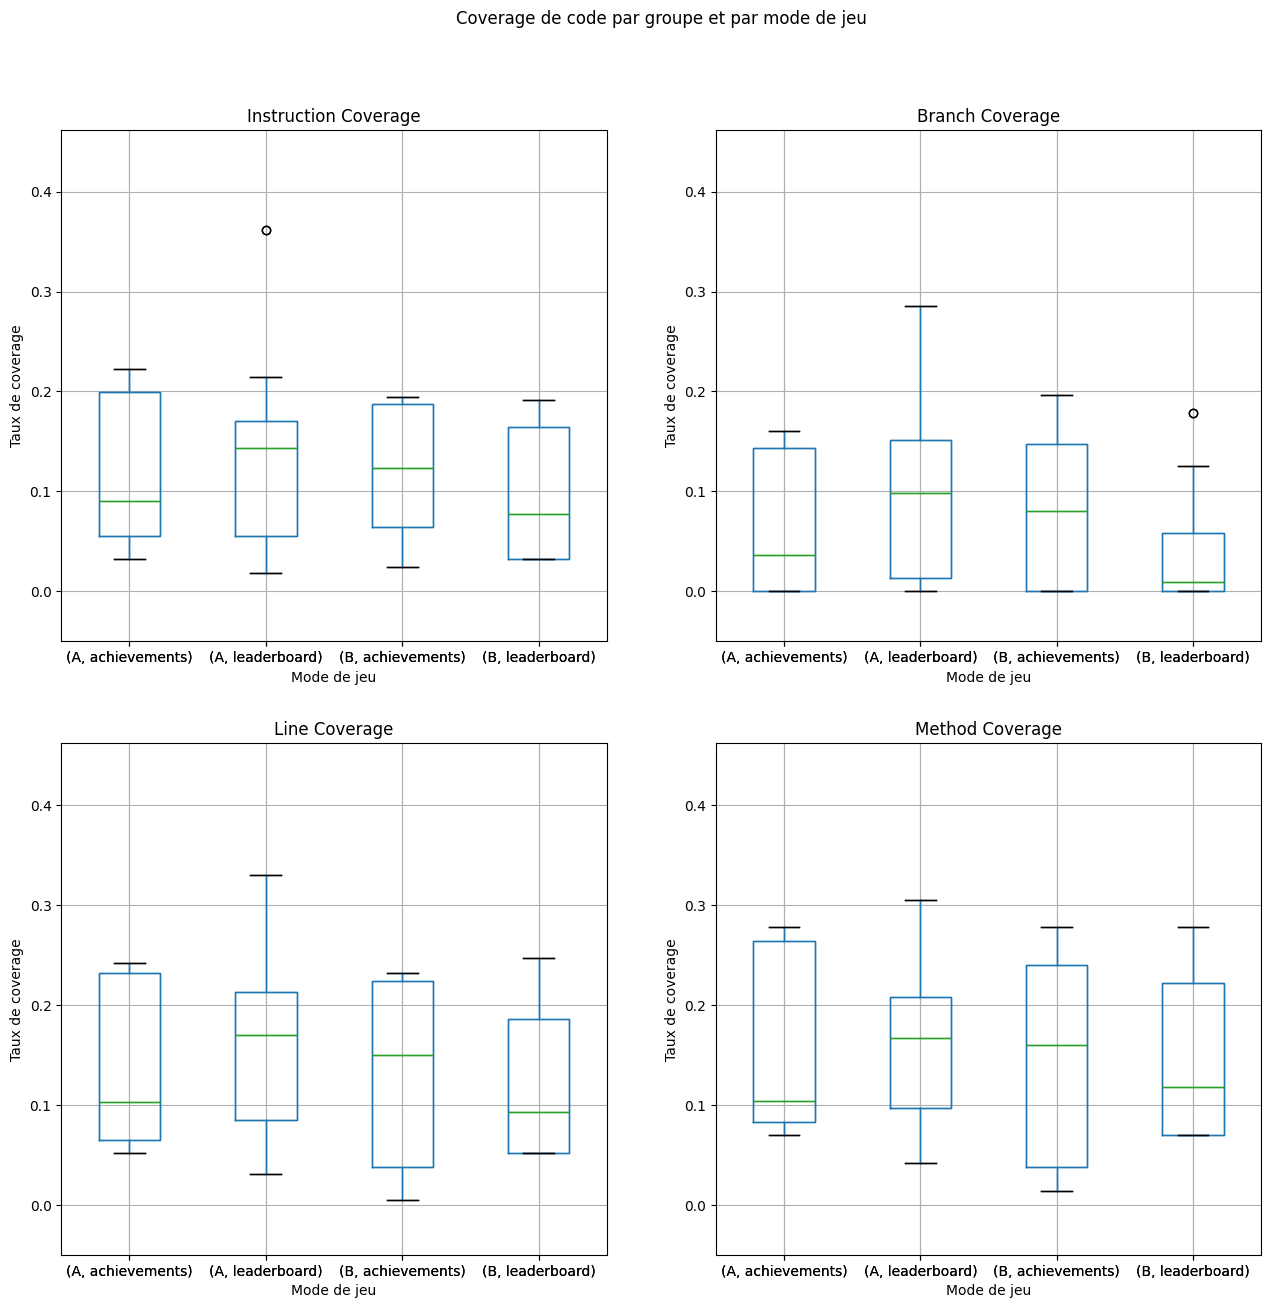

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()

y_max = df_jacoco[cols].max().max() + 0.1

for group in ['A', 'B']:
    for i, metric in enumerate(cols):
        ax = axs[i]
        bp = df_jacoco.boxplot(column=metric, by=['group', 'game_mode'], ax=ax)
        ax.set_title(f'{metric.capitalize()} Coverage')
        ax.set_ylabel('Taux de coverage')
        ax.set_xlabel('Mode de jeu')
        ax.grid(True)
        ax.set_ylim(-0.05, y_max)

plt.suptitle('Coverage de code par groupe et par mode de jeu')
plt.savefig(f"{out_jacoco_path}/coverage_by_game_mode.pdf")
plt.show()

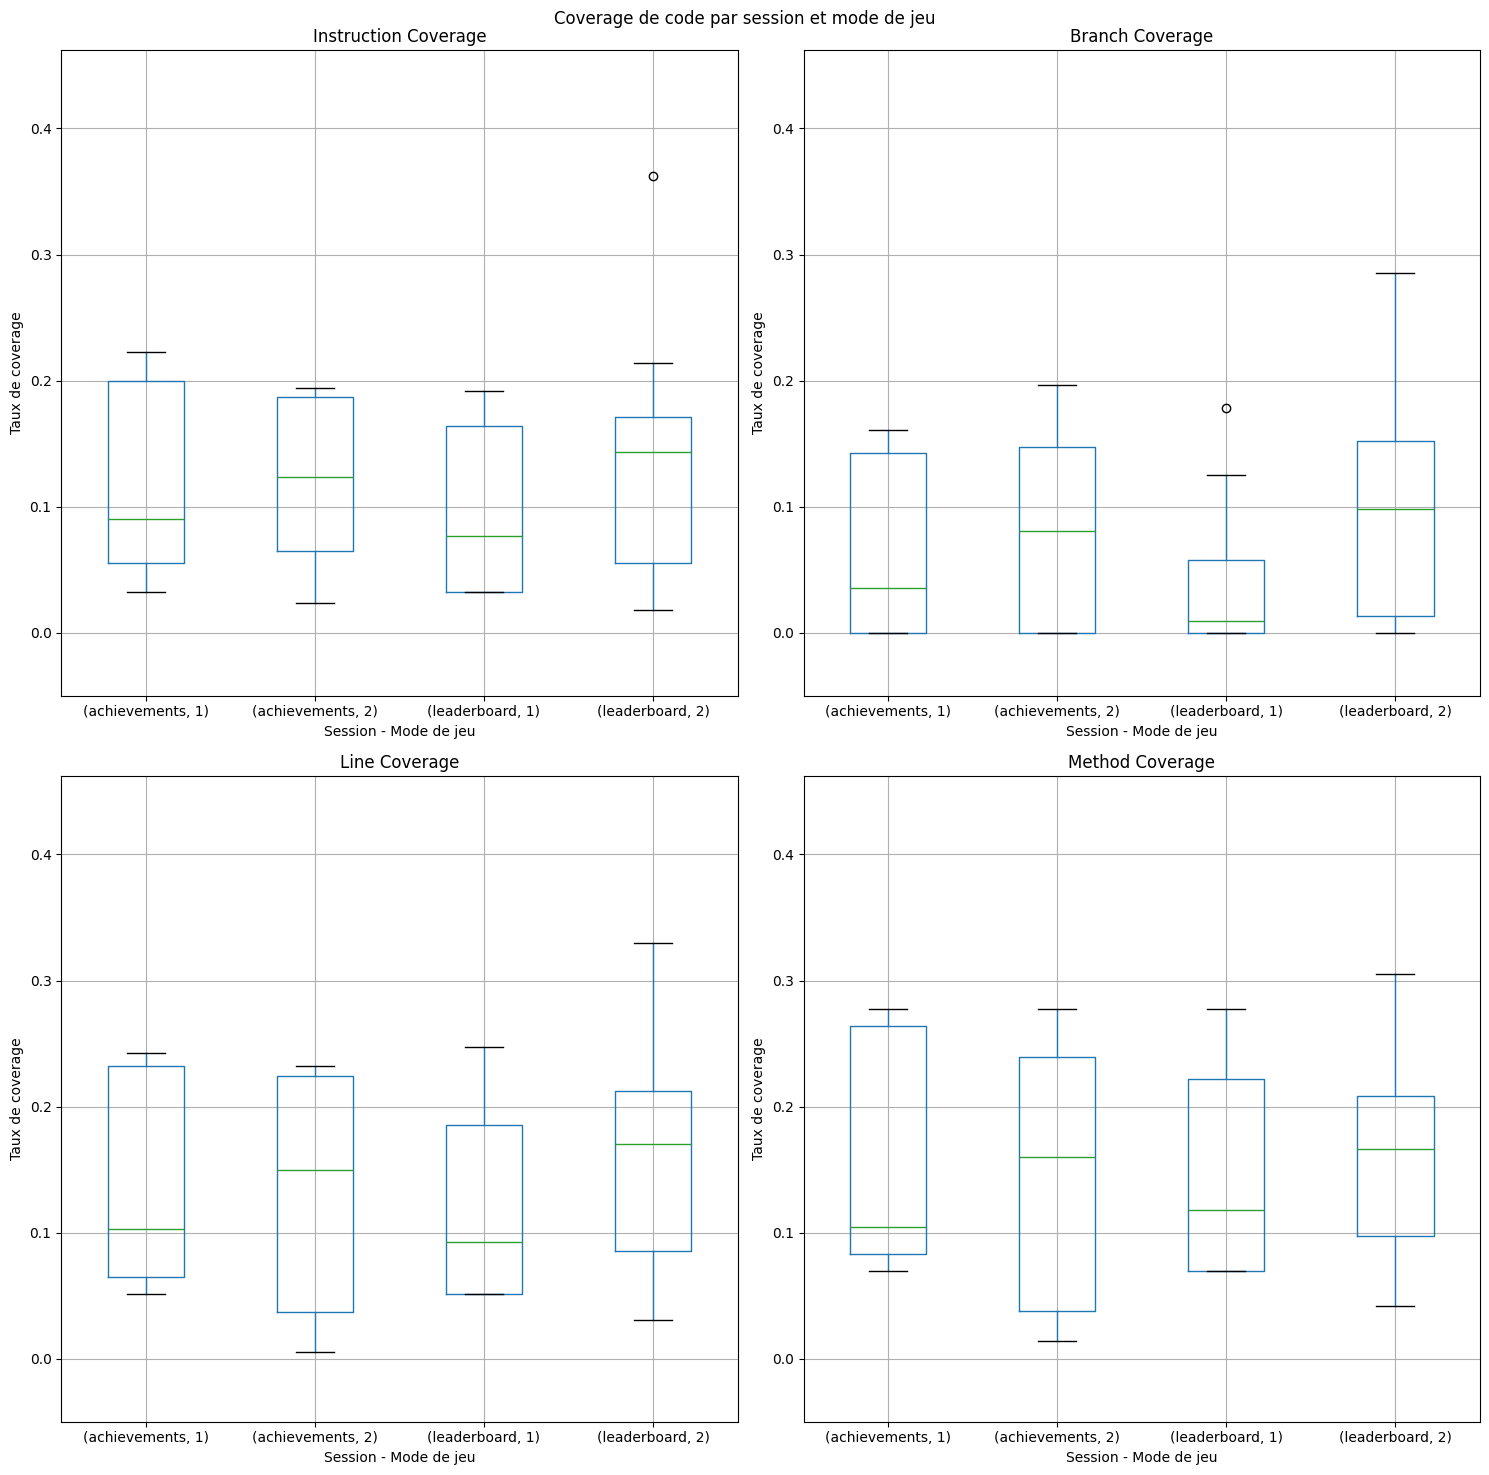

In [128]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()

y_max = df_jacoco[cols].max().max() + 0.1

for i, metric in enumerate(cols):
    ax = axs[i]

    # Boxplot par session
    df_jacoco.boxplot(column=metric, by=['game_mode', 'session'], ax=ax)
    ax.set_title(f'{metric.capitalize()} Coverage')
    ax.set_ylabel('Taux de coverage')
    ax.set_xlabel('Session - Mode de jeu')
    ax.grid(True)
    ax.set_ylim(-0.05, y_max)
    ax.tick_params(axis='x', rotation=0)

plt.suptitle('Coverage de code par mode de jeu et par session')
plt.tight_layout()
plt.savefig(f"{out_jacoco_path}/coverage_by_session_and_game_mode.pdf")
plt.show()
